In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, log_loss

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [3]:
from google.colab import files

uploaded = files.upload()

Saving diabetes_dataset.csv to diabetes_dataset.csv


In [5]:
df = pd.read_csv("diabetes_dataset.csv")
df.dropna(axis=0,subset=['diagnosed_diabetes'],inplace=True)
X = df.drop('diagnosed_diabetes', axis=1)
y = df['diagnosed_diabetes']


In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)


In [7]:
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object"]).columns


In [10]:
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


In [11]:
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])


In [12]:
preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])


In [13]:
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed   = preprocessor.transform(X_val)
X_test_processed  = preprocessor.transform(X_test)


In [27]:
xgb_model = XGBClassifier(
    n_estimators=1000,

    learning_rate=0.05,
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(
    X_train_processed, y_train,
    eval_set=[
        (X_train_processed, y_train),
        (X_val_processed, y_val)
    ],
    verbose=False
)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, ...)

In [28]:
evals_result = xgb_model.evals_result()

train_loss = evals_result["validation_0"]["logloss"]
val_loss   = evals_result["validation_1"]["logloss"]


In [17]:
# Predictions
y_train_pred = xgb_model.predict(X_train_processed)
y_val_pred   = xgb_model.predict(X_val_processed)
y_test_pred  = xgb_model.predict(X_test_processed)

# Probabilities
y_train_prob = xgb_model.predict_proba(X_train_processed)
y_val_prob   = xgb_model.predict_proba(X_val_processed)
y_test_prob  = xgb_model.predict_proba(X_test_processed)

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
val_acc   = accuracy_score(y_val, y_val_pred)
test_acc  = accuracy_score(y_test, y_test_pred)

# Loss
train_loss_final = log_loss(y_train, y_train_prob)
val_loss_final   = log_loss(y_val, y_val_prob)
test_loss_final  = log_loss(y_test, y_test_prob)


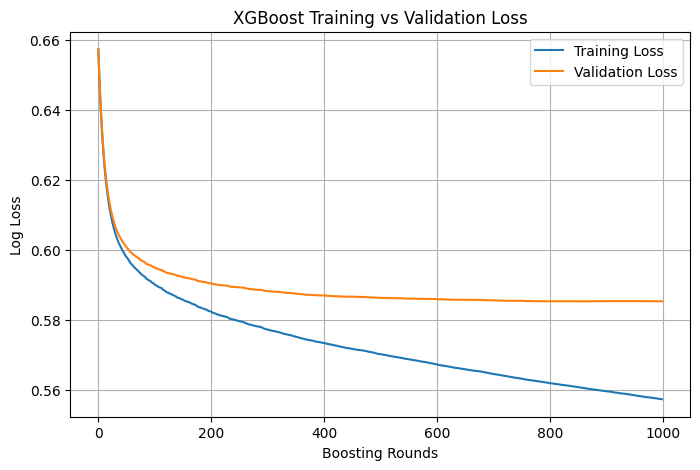

In [18]:
plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Boosting Rounds")
plt.ylabel("Log Loss")
plt.title("XGBoost Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
print("XGBoost Final Results")
print("---------------------")
print(f"Training Accuracy   : {train_acc:.4f}")
print(f"Validation Accuracy : {val_acc:.4f}")
print(f"Test Accuracy       : {test_acc:.4f}")
print(f"Training Loss       : {train_loss_final:.4f}")
print(f"Validation Loss     : {val_loss_final:.4f}")
print(f"Test Loss           : {test_loss_final:.4f}")


XGBoost Final Results
---------------------
Training Accuracy   : 0.7077
Validation Accuracy : 0.6832
Test Accuracy       : 0.6837
Training Loss       : 0.5573
Validation Loss     : 0.5853
Test Loss           : 0.5831


In [20]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    random_state=42
)

rf_model.fit(X_train_processed, y_train)

print("\nRandom Forest Accuracy")
print("Train :", accuracy_score(y_train, rf_model.predict(X_train_processed)))
print("Val   :", accuracy_score(y_val, rf_model.predict(X_val_processed)))
print("Test  :", accuracy_score(y_test, rf_model.predict(X_test_processed)))



Random Forest Accuracy
Train : 0.6586160714285715
Val   : 0.6578571428571428
Test  : 0.6569714285714285
